# Run before

In [27]:
library(tidyverse)
library(repr)
library(tidymodels)

# Download files

In [56]:
sat_scores = read_csv("https://raw.githubusercontent.com/emi31770/proposal/main/datesets/sat_scores.csv")
zip_income = read_csv("https://raw.githubusercontent.com/emi31770/proposal/main/datesets/zipcodes_income.csv")
names(sat_scores) = make.names(names(sat_scores))
names(zip_income) = make.names(names(zip_income))
write_csv(sat_scores, "sat.csv")
write_csv(zip_income, "zip.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  `Zip Code` = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  `Start Time` = col_time(format = ""),
  `End Time` = col_time(format = ""),
  `Student Enrollment` = col_double(),
  `Average Score (SAT Math)` = col_double(),
  `Average Score (SAT Reading)` = col_double(),
  `Average Score (SAT Writing)` = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)



Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)

Parsed with column specification:
cols(
  .default = col_character(),
  Zip.Code = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Start.Time = col_time(format = ""),
  End.Time = col_time(format = ""),
  Student.Enrollment = col_double(),
  Average.Score..SAT.Math. = col_double(),
  Average.Score..SAT.Reading. = col_double(),
  Average.Score..SAT.Writing. = col_double()
)

See spec(...) for full column specifications.



,Zip.Code,Student.Enrollment,Averages.Sum,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,total_pop,total_income,avg_income
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10002,504.7273,1358.909,472.9091,448.5455,437.4545,42400,2718913,64125.31
2,10003,693.2000,1323.600,449.6000,443.4000,430.6000,29270,8191737,279868.02
3,10004,519.2500,1380.250,463.0000,462.0000,455.2500,2470,944925,382560.73
4,10006,747.5000,1268.000,429.5000,419.0000,419.5000,2510,577145,229938.25
5,10009,666.0000,1327.000,454.0000,428.0000,445.0000,33200,2948597,88813.16


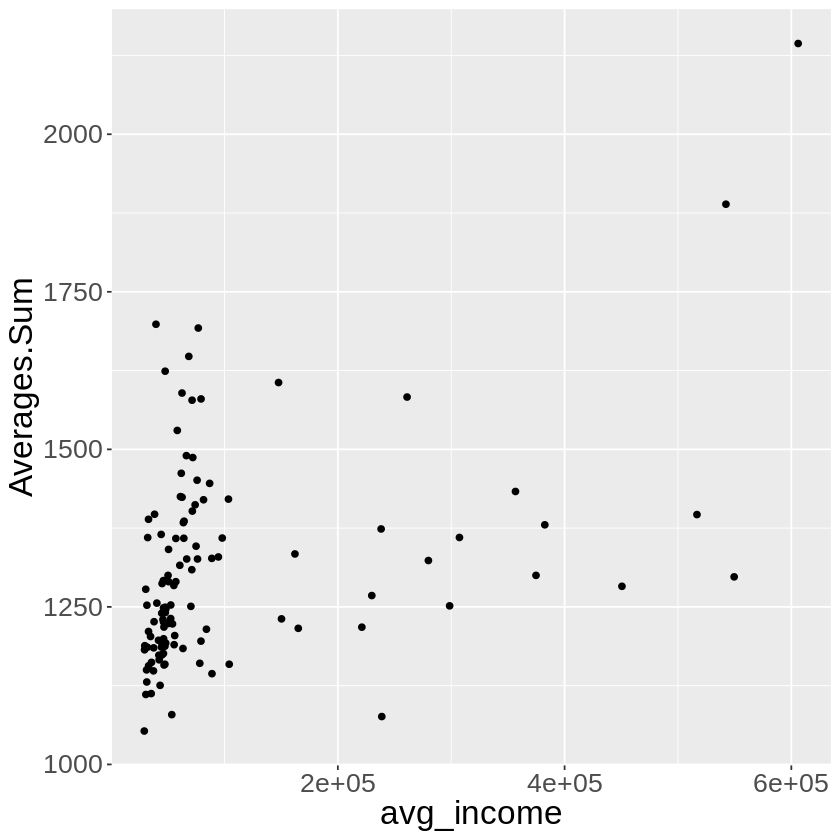

In [87]:
zip_income = read_csv("zip.csv")
sat_scores = read_csv("sat.csv")

zip_income = zip_income %>% filter(state=="NY", country=="USA") %>% 
            mutate(Zip.Code = zipcode) %>% select(Zip.Code, total_pop, total_income, avg_income)

sat_scores = sat_scores %>% mutate(Averages.Sum = Average.Score..SAT.Math. + Average.Score..SAT.Reading. + Average.Score..SAT.Writing.) %>%
                            select(Zip.Code, Student.Enrollment, Averages.Sum, Average.Score..SAT.Math., Average.Score..SAT.Reading., Average.Score..SAT.Writing.) %>%
                            na.omit() %>%
                            group_by(Zip.Code) %>%
                            summarize_all("mean")

joined_tables = merge(x=sat_scores,y=zip_income,by="Zip.Code")

scores_income <- ggplot(joined_tables, aes(x = avg_income, y = Averages.Sum)) +
    geom_point() +
    labs() +
    theme(text = element_text(size=20))

head(joined_tables, 5)
scores_income